# INSTALL REQUIRED LIBRARIES

In [ ]:
pip install numpy matplotlib torch torchvision astropy scikit-image tqdm pytorch-msssim

# MODEL DEFINITION

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from astropy.io import fits
from skimage.transform import resize
from tqdm import tqdm
from pytorch_msssim import ms_ssim, ssim

In [ ]:
class loadData(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith('.fits')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_folder, self.image_files[idx])
        with fits.open(img_path) as hdul:
            img_data = hdul[0].data

            if len(img_data.shape) == 5:
                img_data = img_data[0, 0, 0]
            elif len(img_data.shape) == 4:
                img_data = img_data[0, 0]
            elif len(img_data.shape) == 3:
                img_data = img_data[0]

        img_data = img_data.astype(np.float32)
        img_resized = resize(img_data, (187, 187), order=1, preserve_range=True)
        img_normalized = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized))
        img_tensor = torch.tensor(img_normalized).float().unsqueeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        pre_pool = self.conv(x)
        pooled = self.pool(pre_pool)
        return pooled, pre_pool

class UNetEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(UNetEncoder, self).__init__()
        self.conv1 = ConvBlock(1, 16)
        self.conv2 = ConvBlock(16, 32)
        self.conv3 = ConvBlock(32, 64)
        self.conv4 = ConvBlock(64, 128)

        self.pool = nn.AdaptiveAvgPool2d((7, 7))

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, latent_dim)

    def forward(self, x):
        x1, skip1 = self.conv1(x)
        x2, skip2 = self.conv2(x1)
        x3, skip3 = self.conv3(x2)
        x4, skip4 = self.conv4(x3)

        x5 = self.pool(x4)
        x_flat = self.flatten(x5)
        latent = self.fc(x_flat)

        return latent, [skip1, skip2, skip3, skip4]

class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels // 2 + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = self.upconv(x)

        if x.size() != skip.size():
            x = nn.functional.interpolate(x, size=skip.size()[2:])

        x = torch.cat([x, skip], dim=1)

        x = self.conv(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(UNetDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
        self.unflatten = nn.Unflatten(1, (128, 7, 7))

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )  # 14x14

        self.up2 = UpBlock(128, 128, 64)
        self.up3 = UpBlock(64, 64, 32)
        self.up4 = UpBlock(32, 32, 16)

        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.merge_first_skip = nn.Sequential(
            nn.Conv2d(16 + 16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((187, 187))

        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, skip_features):
        skip1, skip2, skip3, skip4 = skip_features

        x = self.fc(x)
        x = self.unflatten(x)

        x = self.upconv1(x)

        x = self.up2(x, skip4)
        x = self.up3(x, skip3)
        x = self.up4(x, skip2)

        x = self.up5(x)

        x = nn.functional.interpolate(x, size=(187, 187))

        x = torch.cat([x, skip1], dim=1)
        x = self.merge_first_skip(x)

        x = self.adaptive_pool(x)

        x = self.final_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, latent_dim=8):
        super(UNet, self).__init__()
        self.encoder = UNetEncoder(latent_dim)
        self.decoder = UNetDecoder(latent_dim)

    def forward(self, x):
        latent, skip_features = self.encoder(x)
        reconstructed = self.decoder(latent, skip_features)

        return reconstructed, latent

    def encode(self, x):
        latent, _ = self.encoder(x)
        return latent

    def decode(self, x):
        return self.decoder(x, [torch.zeros((x.size(0), 16, 187, 187), device=x.device),
                              torch.zeros((x.size(0), 32, 93, 93), device=x.device),
                              torch.zeros((x.size(0), 64, 46, 46), device=x.device),
                              torch.zeros((x.size(0), 128, 23, 23), device=x.device)])

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for data in tqdm(dataloader, desc="Training"):
        inputs = data.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validation"):
            inputs = data.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    mse_values = []
    ssim_values = []
    ms_ssim_values = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Evaluating"):
            inputs = data.to(device)
            outputs, _ = model(inputs)

            mse = F.mse_loss(outputs, inputs).item()
            mse_values.append(mse)

            ssim_val = ssim(inputs, outputs, data_range=1.0).item()
            ssim_values.append(ssim_val)

            ms_ssim_val = ms_ssim(inputs, outputs, data_range=1.0).item()
            ms_ssim_values.append(ms_ssim_val)

    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)
    avg_ms_ssim = np.mean(ms_ssim_values)

    return {
        'MSE': avg_mse,
        'SSIM': avg_ssim,
        'MS-SSIM': avg_ms_ssim
    }

def visualize_reconstructions(model, dataloader, num_images=5, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    images = []
    reconstructions = []

    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            outputs, _ = model(inputs)

            inputs_np = inputs.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            for i in range(inputs.shape[0]):
                images.append(inputs_np[i, 0])
                reconstructions.append(outputs_np[i, 0])

                if len(images) >= num_images:
                    break

            if len(images) >= num_images:
                break

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i], cmap='inferno')
        plt.title(f'Original {i+1}')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructions[i], cmap='inferno')
        plt.title(f'Reconstructed {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_per_image_metrics(model, dataloader, num_images=5, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    images = []
    reconstructions = []
    mse_values = []
    ssim_values = []
    ms_ssim_values = []

    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            outputs, _ = model(inputs)

            inputs_np = inputs.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            for i in range(inputs.shape[0]):
                images.append(inputs_np[i, 0])
                reconstructions.append(outputs_np[i, 0])

                single_input = inputs[i:i+1]
                single_output = outputs[i:i+1]

                mse = F.mse_loss(single_output, single_input).item()
                mse_values.append(mse)

                ssim_val = ssim(single_input, single_output, data_range=1.0).item()
                ssim_values.append(ssim_val)

                ms_ssim_val = ms_ssim(single_input, single_output, data_range=1.0).item()
                ms_ssim_values.append(ms_ssim_val)

                if len(images) >= num_images:
                    break

            if len(images) >= num_images:
                break

    fig, axes = plt.subplots(3, num_images, figsize=(15, 9))

    for i in range(num_images):
        axes[0, i].imshow(images[i], cmap='inferno')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructions[i], cmap='inferno')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')

        axes[2, i].axis('off')
        axes[2, i].text(0.5, 0.7, f"MSE: {mse_values[i]:.6f}", ha='center')
        axes[2, i].text(0.5, 0.5, f"SSIM: {ssim_values[i]:.6f}", ha='center')
        axes[2, i].text(0.5, 0.3, f"MS-SSIM: {ms_ssim_values[i]:.6f}", ha='center')

    plt.tight_layout()
    plt.suptitle('Per-Image Reconstruction Quality', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    return {
        'MSE': mse_values,
        'SSIM': ssim_values,
        'MS-SSIM': ms_ssim_values
    }

def extract_latent_representations(model, dataloader, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    latent_vectors = []
    image_names = []

    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader, desc="Extracting latent vectors")):
            inputs = data.to(device)

            latent, _ = model.encoder(inputs)

            latent_np = latent.cpu().numpy()

            latent_vectors.extend(latent_np)

            for j in range(inputs.shape[0]):
                image_names.append(f"Image_{i*dataloader.batch_size + j}")

    latent_vectors = np.array(latent_vectors)

    return latent_vectors, image_names

def visualize_latent_space(latent_vectors, image_names=None):
    n_samples = latent_vectors.shape[0]

    if latent_vectors.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1])

        if image_names and len(image_names) <= 30:  # Only label if not too many points
            for i, txt in enumerate(image_names):
                plt.annotate(txt, (latent_vectors[i, 0], latent_vectors[i, 1]))

        plt.title('Latent Space Visualization (2D)')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        from sklearn.decomposition import PCA

        pca = PCA(n_components=2)
        latent_2d_pca = pca.fit_transform(latent_vectors)

        plt.figure(figsize=(12, 10))

        plt.subplot(1, 2 if n_samples >= 5 else 1, 1)
        plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1])
        plt.title('PCA Visualization')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)

        if n_samples >= 5:
            from sklearn.manifold import TSNE
            # Adjust perplexity based on sample size (must be less than n_samples)
            perplexity = min(30, n_samples // 2)

            try:
                tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
                latent_2d_tsne = tsne.fit_transform(latent_vectors)

                plt.subplot(1, 2, 2)
                plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1])
                plt.title(f't-SNE Visualization (perplexity={perplexity})')
                plt.xlabel('t-SNE Component 1')
                plt.ylabel('t-SNE Component 2')
                plt.grid(True)
            except Exception as e:
                print(f"t-SNE failed: {e}. Skipping t-SNE visualization.")

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        full_pca = PCA()
        full_pca.fit(latent_vectors)
        plt.bar(range(1, len(full_pca.explained_variance_ratio_) + 1),
                full_pca.explained_variance_ratio_,
                alpha=0.7)
        plt.step(range(1, len(full_pca.explained_variance_ratio_) + 1),
                np.cumsum(full_pca.explained_variance_ratio_),
                where='mid', color='red')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.title('PCA Explained Variance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return latent_2d_pca if latent_vectors.shape[1] > 2 else latent_vectors

def export_latent_vectors(latent_vectors, image_names, filepath):
    """Export latent vectors to CSV and NPZ files"""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    np.savez(f"{filepath}.npz",
             latent_vectors=latent_vectors,
             image_names=np.array(image_names))

    import pandas as pd
    df = pd.DataFrame(latent_vectors)
    df.columns = [f"dim_{i}" for i in range(latent_vectors.shape[1])]
    df['image_name'] = image_names
    df.to_csv(f"{filepath}.csv", index=False)

    print(f"Latent vectors exported to {filepath}.npz and {filepath}.csv")
    return df

def decode_from_latent(model, latent_vector, device=None):
    """Decode a latent vector back to image"""
    if device is None:
        device = next(model.parameters()).device

    latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        decoded_img = model.decode(latent_tensor)

    decoded_img_np = decoded_img.cpu().squeeze(0).squeeze(0).numpy()

    return decoded_img_np

def visualize_latent_features(model, latent_vectors, image_names, device, export_dir=None, prefix="val"):
    """Enhanced visualization of latent space features"""
    num_examples = min(5, len(latent_vectors))
    example_indices = np.random.choice(len(latent_vectors), num_examples, replace=False)

    latent_min = np.min(latent_vectors)
    latent_max = np.max(latent_vectors)
    latent_mean = np.mean(latent_vectors)
    print(f"Latent vector range: [{latent_min:.6f}, {latent_max:.6f}], mean: {latent_mean:.6f}")

    fig, axes = plt.subplots(3, num_examples, figsize=(18, 9))

    for i, idx in enumerate(example_indices):
        latent_vector = latent_vectors[idx]
        print(f"Vector {idx} range: [{latent_vector.min():.6f}, {latent_vector.max():.6f}]")

        decoded_img = decode_from_latent(model, latent_vector, device)

        img_min = decoded_img.min()
        img_max = decoded_img.max()
        img_mean = decoded_img.mean()
        print(f"Decoded image {idx} range: [{img_min:.6f}, {img_max:.6f}], mean: {img_mean:.6f}")

        im1 = axes[0, i].imshow(decoded_img, cmap='plasma')
        axes[0, i].set_title(f"Auto-scaled")
        axes[0, i].axis('off')
        fig.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)

        if decoded_img.std() > 0:
            normalized_img = (decoded_img - decoded_img.mean()) / decoded_img.std()
            im2 = axes[1, i].imshow(normalized_img, cmap='seismic', vmin=-2, vmax=2)
            axes[1, i].set_title(f"Z-score normalized")
        else:
            im2 = axes[1, i].imshow(decoded_img, cmap='seismic')
            axes[1, i].set_title(f"Z-score (fallback)")
        axes[1, i].axis('off')
        fig.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

        if decoded_img.std() > 0:
            threshold = decoded_img.mean() + 0.1 * decoded_img.std()
            binary_img = (decoded_img > threshold).astype(float)
            im3 = axes[2, i].imshow(binary_img, cmap='hot')
            axes[2, i].set_title(f"Thresholded")
        else:
            binary_img = (decoded_img > decoded_img.mean()).astype(float)
            im3 = axes[2, i].imshow(binary_img, cmap='hot')
            axes[2, i].set_title(f"Thresholded (fallback)")
        axes[2, i].axis('off')
        fig.colorbar(im3, ax=axes[2, i], fraction=0.046, pad=0.04)

    plt.suptitle(f"{prefix.capitalize()} Latent Space Visualizations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    if export_dir:
        for i, idx in enumerate(example_indices[:3]):  # Save first 3 examples
            latent_vector = latent_vectors[idx]
            decoded_img = decode_from_latent(model, latent_vector, device)

            fig, ax = plt.subplots(1, 3, figsize=(18, 5))

            im1 = ax[0].imshow(decoded_img, cmap='plasma')
            ax[0].set_title(f"Auto-scaled")
            ax[0].axis('off')
            plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)

            if decoded_img.std() > 0:
                normalized_img = (decoded_img - decoded_img.mean()) / decoded_img.std()
                im2 = ax[1].imshow(normalized_img, cmap='seismic', vmin=-2, vmax=2)
                ax[1].set_title(f"Z-score normalized")
            else:
                im2 = ax[1].imshow(decoded_img, cmap='seismic')
                ax[1].set_title(f"Z-score (fallback)")
            ax[1].axis('off')
            plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

            if decoded_img.std() > 0:
                threshold = decoded_img.mean() + 0.1 * decoded_img.std()
                binary_img = (decoded_img > threshold).astype(float)
                im3 = ax[2].imshow(binary_img, cmap='hot')
                ax[2].set_title(f"Thresholded")
            else:
                binary_img = (decoded_img > decoded_img.mean()).astype(float)
                im3 = ax[2].imshow(binary_img, cmap='hot')
                ax[2].set_title(f"Thresholded (fallback)")
            ax[2].axis('off')
            plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

            plt.suptitle(f"{prefix.capitalize()} Latent Vector {idx} Visualizations", fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.savefig(os.path.join(export_dir, f"{prefix}_latent_viz_{idx}.png"), dpi=300)
            plt.close()

# ACCESSING ANY LATENT IMAGE

In [ ]:
def access_specific_latent_image(model, dataset, image_index, device=None, export_dir=None, save_prefix=None):
    """
    Access an image, encode it, and visualize both original and reconstructed versions.

    """
    if device is None:
        device = next(model.parameters()).device

    if image_index >= len(dataset):
        raise IndexError(f"Image index {image_index} out of range for dataset with {len(dataset)} images")

    input_image = dataset[image_index].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        reconstruction, latent = model(input_image)
        latent_vector = latent.cpu().numpy()[0]

    input_np = input_image.cpu().squeeze(0).squeeze(0).numpy()
    recon_np = reconstruction.cpu().squeeze(0).squeeze(0).numpy()

    print(f"Latent vector for image {image_index}:")
    print(latent_vector)
    print(f"Range: [{latent_vector.min():.6f}, {latent_vector.max():.6f}]")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axes[0].imshow(input_np, cmap='plasma')
    axes[0].set_title(f"Original Image {image_index}")
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    im2 = axes[1].imshow(recon_np, cmap='plasma')
    axes[1].set_title(f"Reconstruction from Latent Space")
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    if export_dir and save_prefix:
        os.makedirs(export_dir, exist_ok=True)

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        im1 = axes[0, 0].imshow(input_np, cmap='plasma')
        axes[0, 0].set_title(f"Original Image {image_index}")
        axes[0, 0].axis('off')
        plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

        im2 = axes[0, 1].imshow(recon_np, cmap='plasma')
        axes[0, 1].set_title(f"Reconstruction")
        axes[0, 1].axis('off')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

        diff = np.abs(input_np - recon_np)
        im3 = axes[1, 0].imshow(diff, cmap='hot')
        axes[1, 0].set_title(f"Absolute Difference")
        axes[1, 0].axis('off')
        plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

        im4 = axes[1, 1].imshow(recon_np, cmap='viridis')
        axes[1, 1].set_title(f"Auto-scaled Reconstruction")
        axes[1, 1].axis('off')
        plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

        plt.figtext(0.5, 0.01, f"Latent vector: {latent_vector}", ha="center", fontsize=9,
                   bbox={"facecolor":"white", "alpha":0.5, "pad":5})

        plt.suptitle(f"{save_prefix} Image {image_index} Latent Space Analysis", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(os.path.join(export_dir, f"{save_prefix}_image_{image_index}_latent_analysis.png"), dpi=300)
        plt.close()

    return latent_vector

# TEST INFERENCE SETUP

In [ ]:
def infer_on_test_data(model_path, test_data_folder, device, metrics_output_path="metrics.txt",
                      export_dir="exports", specific_indices=-1):
    """
    Loads a model, infers on test data, visualizes some results, exports to metrics.txt
    """

    os.makedirs(export_dir, exist_ok=True)

    model = UNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_dataset = loadData(test_data_folder)
    full_test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    all_mse_values = []
    all_ssim_values = []
    all_ms_ssim_values = []

    with torch.no_grad():
        for data in tqdm(full_test_dataloader, desc="Inferring"):
            inputs = data.to(device)
            outputs, _ = model(inputs)

            for i in range(inputs.size(0)):
                single_input = inputs[i:i+1]
                single_output = outputs[i:i+1]

                mse = F.mse_loss(single_output, single_input).item()
                all_mse_values.append(mse)

                ssim_val = ssim(single_input, single_output, data_range=1.0).item()
                all_ssim_values.append(ssim_val)

                ms_ssim_val = ms_ssim(single_input, single_output, data_range=1.0).item()
                all_ms_ssim_values.append(ms_ssim_val)

    avg_mse = np.mean(all_mse_values)
    avg_ssim = np.mean(all_ssim_values)
    avg_ms_ssim = np.mean(all_ms_ssim_values)

    with open(metrics_output_path, 'w') as f:
        f.write("Metrics for all test images:\n\n")
        f.write("MSE Values:\n")
        f.write(str(all_mse_values) + "\n\n")
        f.write("SSIM Values:\n")
        f.write(str(all_ssim_values) + "\n\n")
        f.write("MS-SSIM Values:\n")
        f.write(str(all_ms_ssim_values) + "\n\n")
        f.write("Average Metrics:\n")
        f.write(f"Average MSE: {avg_mse:.6f}\n")
        f.write(f"Average SSIM: {avg_ssim:.6f}\n")
        f.write(f"Average MS-SSIM: {avg_ms_ssim:.6f}\n")

    print(f"Metrics saved to {metrics_output_path}")

    num_visualize = 5
    random_indices = np.random.choice(len(test_dataset), num_visualize, replace=False)
    visualize_dataset = torch.utils.data.Subset(test_dataset, random_indices)
    visualize_dataloader = DataLoader(visualize_dataset, batch_size=1, shuffle=False)

    image_metrics = visualize_per_image_metrics(model, visualize_dataloader, num_images=num_visualize, device=device)

    complete_metrics = {
        'MSE': all_mse_values,
        'SSIM': all_ssim_values,
        'MS-SSIM': all_ms_ssim_values,
        'Average MSE': avg_mse,
        'Average SSIM': avg_ssim,
        'Average MS-SSIM': avg_ms_ssim
    }

    print("\nExtracting and visualizing latent space from test data...")
    latent_vectors, image_names = extract_latent_representations(model, full_test_dataloader, device)

    latent_min = np.min(latent_vectors)
    latent_max = np.max(latent_vectors)
    print(f"Latent vector range in test data: [{latent_min:.6f}, {latent_max:.6f}]")

    visualize_latent_space(latent_vectors, image_names)

    print("\nExporting latent vectors from test data...")
    export_filepath = os.path.join(export_dir, "test_latent_vectors")
    export_df = export_latent_vectors(latent_vectors, image_names, export_filepath)

    print("\nVisualizing specific examples from test latent space...")

    if specific_indices == -1:
        num_examples = min(5, len(latent_vectors))
        example_indices = np.random.choice(len(latent_vectors), num_examples, replace=False)
        print(f"Using random indices for latent space visualization: {example_indices}")
    else:
        if isinstance(specific_indices, int):
            specific_indices = [specific_indices]
        example_indices = specific_indices
        print(f"Using specified indices for latent space visualization: {example_indices}")

    num_examples = len(example_indices)
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    if num_examples == 1:
        axes = [axes]

    for i, idx in enumerate(example_indices):
        if idx >= len(latent_vectors):
            print(f"Warning: Index {idx} out of range, skipping")
            continue

        latent_vector = latent_vectors[idx]

        print(f"Vector {idx} range: [{latent_vector.min():.6f}, {latent_vector.max():.6f}]")

        decoded_img = decode_from_latent(model, latent_vector, device)

        im = axes[i].imshow(decoded_img, cmap='plasma')
        axes[i].set_title(f"From test latent\nspace {idx}")
        axes[i].axis('off')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print("\nSaving example reconstructed images from test latent space...")
    for i, idx in enumerate(example_indices[:3]):
        if idx >= len(latent_vectors):
            continue

        latent_vector = latent_vectors[idx]
        decoded_img = decode_from_latent(model, latent_vector, device)

        plt.figure(figsize=(6, 6))
        im = plt.imshow(decoded_img, cmap='plasma')
        plt.title(f"Reconstructed from Test Latent Vector {idx}")
        plt.colorbar(im)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(export_dir, f"test_latent_reconstruction_{idx}.png"), dpi=300)
        plt.close()

    if specific_indices != -1:
        for idx in example_indices:
            if idx >= len(test_dataset):
                print(f"Warning: Index {idx} out of range for dataset with {len(test_dataset)} images")
                continue

            print(f"\nAnalyzing original test image {idx}:")
            access_specific_latent_image(model, test_dataset, idx,
                                        device=device,
                                        export_dir=export_dir,
                                        save_prefix="test")

    return complete_metrics

def run_test_inference(specific_indices=-1):
    """
    Independent function to run inference on test data only

    """
    print("\n" + "="*50)
    print("RUNNING TEST DATA INFERENCE")
    print("="*50)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    export_dir = 'test_results'
    os.makedirs(export_dir, exist_ok=True)

    try:
        test_data_folder = '/kaggle/input/stardata'  ######### PUT THE PATH TO TEST FOLDER HERE ###########
        os.listdir(test_data_folder)
        print(f"Using Kaggle test data folder: {test_data_folder}")
    except:
        try:
            test_data_folder = 'test_data'
            os.listdir(test_data_folder)
            print(f"Using local test data folder: {test_data_folder}")
        except:
            test_data_folder = 'data'
            print(f"Test folder not found, using data folder: {test_data_folder}")

    model_path = 'model_exports/unet_autoencoder_final.pth'   ########### PATH TO THE SAVED AUTOENCODER  #############
    metrics_output_path = os.path.join(export_dir, 'test_metrics.txt')

    print(f"Model path: {model_path}")
    print(f"Metrics will be saved to: {metrics_output_path}")
    print(f"Visualizations will be saved to: {export_dir}")

    metrics = infer_on_test_data(
        model_path=model_path,
        test_data_folder=test_data_folder,
        device=device,
        metrics_output_path=metrics_output_path,
        export_dir=export_dir,
        specific_indices=specific_indices
    )

    print("\nTest inference complete!")
    print("="*50)

    return metrics

# TRAINING

Loading dataset...
Using data folder: /kaggle/input/stardata


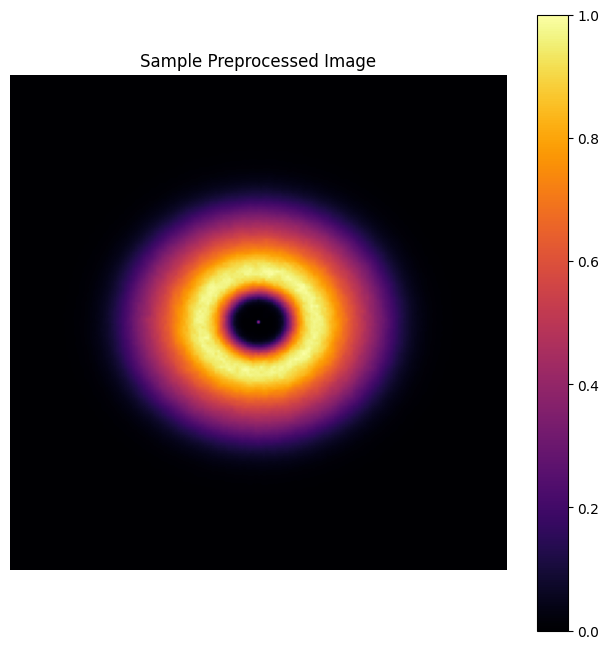

Using device: cuda
Model has 1,037,081 trainable parameters
Starting training for 150 epochs...


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Epoch 1/150: Train Loss: 0.5487, Val Loss: 0.6412


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Epoch 2/150: Train Loss: 0.4139, Val Loss: 0.5442


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


Epoch 3/150: Train Loss: 0.3406, Val Loss: 0.4589


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Epoch 4/150: Train Loss: 0.2910, Val Loss: 0.4029


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Epoch 5/150: Train Loss: 0.2643, Val Loss: 0.3423


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Epoch 6/150: Train Loss: 0.2402, Val Loss: 0.2851


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Epoch 7/150: Train Loss: 0.2245, Val Loss: 0.2446


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Epoch 8/150: Train Loss: 0.2098, Val Loss: 0.2257


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 9/150: Train Loss: 0.2023, Val Loss: 0.2100


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Epoch 10/150: Train Loss: 0.1969, Val Loss: 0.2022


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


Epoch 11/150: Train Loss: 0.1931, Val Loss: 0.1942


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


Epoch 12/150: Train Loss: 0.1886, Val Loss: 0.1874


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Epoch 13/150: Train Loss: 0.1862, Val Loss: 0.1839


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


Epoch 14/150: Train Loss: 0.1838, Val Loss: 0.1785


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Epoch 15/150: Train Loss: 0.1824, Val Loss: 0.1778


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Epoch 16/150: Train Loss: 0.1824, Val Loss: 0.1769


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Epoch 17/150: Train Loss: 0.1818, Val Loss: 0.1755


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Epoch 18/150: Train Loss: 0.1821, Val Loss: 0.1759


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Epoch 19/150: Train Loss: 0.1799, Val Loss: 0.1741


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Epoch 20/150: Train Loss: 0.1784, Val Loss: 0.1734


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


Epoch 21/150: Train Loss: 0.1791, Val Loss: 0.1721


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


Epoch 22/150: Train Loss: 0.1784, Val Loss: 0.1721


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch 23/150: Train Loss: 0.1795, Val Loss: 0.1717


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


Epoch 24/150: Train Loss: 0.1803, Val Loss: 0.1720


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 25/150: Train Loss: 0.1775, Val Loss: 0.1725


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 26/150: Train Loss: 0.1772, Val Loss: 0.1706


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


Epoch 27/150: Train Loss: 0.1782, Val Loss: 0.1703


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Epoch 28/150: Train Loss: 0.1780, Val Loss: 0.1713


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Epoch 29/150: Train Loss: 0.1766, Val Loss: 0.1707


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


Epoch 30/150: Train Loss: 0.1778, Val Loss: 0.1700


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 31/150: Train Loss: 0.1796, Val Loss: 0.1708


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Epoch 32/150: Train Loss: 0.1763, Val Loss: 0.1700


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


Epoch 33/150: Train Loss: 0.1753, Val Loss: 0.1700


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Epoch 34/150: Train Loss: 0.1752, Val Loss: 0.1704


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Epoch 35/150: Train Loss: 0.1757, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


Epoch 36/150: Train Loss: 0.1758, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Epoch 37/150: Train Loss: 0.1754, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Epoch 38/150: Train Loss: 0.1760, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Epoch 39/150: Train Loss: 0.1770, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Epoch 40/150: Train Loss: 0.1766, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Epoch 41/150: Train Loss: 0.1763, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Epoch 42/150: Train Loss: 0.1757, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


Epoch 43/150: Train Loss: 0.1752, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 44/150: Train Loss: 0.1773, Val Loss: 0.1701


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


Epoch 45/150: Train Loss: 0.1752, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


Epoch 46/150: Train Loss: 0.1788, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Epoch 47/150: Train Loss: 0.1763, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Epoch 48/150: Train Loss: 0.1748, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Epoch 49/150: Train Loss: 0.1749, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Epoch 50/150: Train Loss: 0.1763, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Epoch 51/150: Train Loss: 0.1784, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Epoch 52/150: Train Loss: 0.1762, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Epoch 53/150: Train Loss: 0.1747, Val Loss: 0.1707


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch 54/150: Train Loss: 0.1762, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


Epoch 55/150: Train Loss: 0.1754, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 56/150: Train Loss: 0.1753, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Epoch 57/150: Train Loss: 0.1772, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Epoch 58/150: Train Loss: 0.1747, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch 59/150: Train Loss: 0.1764, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


Epoch 60/150: Train Loss: 0.1750, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Epoch 61/150: Train Loss: 0.1747, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 62/150: Train Loss: 0.1765, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Epoch 63/150: Train Loss: 0.1750, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Epoch 64/150: Train Loss: 0.1759, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Epoch 65/150: Train Loss: 0.1751, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch 66/150: Train Loss: 0.1752, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Epoch 67/150: Train Loss: 0.1751, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 68/150: Train Loss: 0.1748, Val Loss: 0.1702


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Epoch 69/150: Train Loss: 0.1743, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


Epoch 70/150: Train Loss: 0.1759, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 71/150: Train Loss: 0.1746, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch 72/150: Train Loss: 0.1744, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Epoch 73/150: Train Loss: 0.1748, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Epoch 74/150: Train Loss: 0.1745, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


Epoch 75/150: Train Loss: 0.1742, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Epoch 76/150: Train Loss: 0.1744, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Epoch 77/150: Train Loss: 0.1747, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Epoch 78/150: Train Loss: 0.1734, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Epoch 79/150: Train Loss: 0.1737, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Epoch 80/150: Train Loss: 0.1739, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Epoch 81/150: Train Loss: 0.1751, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Epoch 82/150: Train Loss: 0.1755, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


Epoch 83/150: Train Loss: 0.1739, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Epoch 84/150: Train Loss: 0.1756, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Epoch 85/150: Train Loss: 0.1758, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Epoch 86/150: Train Loss: 0.1741, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch 87/150: Train Loss: 0.1754, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


Epoch 88/150: Train Loss: 0.1750, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 89/150: Train Loss: 0.1768, Val Loss: 0.1714


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Epoch 90/150: Train Loss: 0.1749, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 91/150: Train Loss: 0.1760, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Epoch 92/150: Train Loss: 0.1751, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch 93/150: Train Loss: 0.1742, Val Loss: 0.1702


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Epoch 94/150: Train Loss: 0.1738, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


Epoch 95/150: Train Loss: 0.1747, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Epoch 96/150: Train Loss: 0.1751, Val Loss: 0.1701


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Epoch 97/150: Train Loss: 0.1754, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Epoch 98/150: Train Loss: 0.1750, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


Epoch 99/150: Train Loss: 0.1750, Val Loss: 0.1711


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


Epoch 100/150: Train Loss: 0.1750, Val Loss: 0.1706


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Epoch 101/150: Train Loss: 0.1754, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Epoch 102/150: Train Loss: 0.1745, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Epoch 103/150: Train Loss: 0.1743, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


Epoch 104/150: Train Loss: 0.1758, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Epoch 105/150: Train Loss: 0.1746, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Epoch 106/150: Train Loss: 0.1744, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


Epoch 107/150: Train Loss: 0.1741, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Epoch 108/150: Train Loss: 0.1739, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 109/150: Train Loss: 0.1752, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Epoch 110/150: Train Loss: 0.1757, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 111/150: Train Loss: 0.1742, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


Epoch 112/150: Train Loss: 0.1738, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Epoch 113/150: Train Loss: 0.1740, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


Epoch 114/150: Train Loss: 0.1743, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


Epoch 115/150: Train Loss: 0.1775, Val Loss: 0.1716


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Epoch 116/150: Train Loss: 0.1747, Val Loss: 0.1723


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Epoch 117/150: Train Loss: 0.1756, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch 118/150: Train Loss: 0.1737, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 119/150: Train Loss: 0.1745, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


Epoch 120/150: Train Loss: 0.1740, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


Epoch 121/150: Train Loss: 0.1758, Val Loss: 0.1699


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 122/150: Train Loss: 0.1751, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


Epoch 123/150: Train Loss: 0.1750, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch 124/150: Train Loss: 0.1753, Val Loss: 0.1694


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch 125/150: Train Loss: 0.1762, Val Loss: 0.1707


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 126/150: Train Loss: 0.1743, Val Loss: 0.1716


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


Epoch 127/150: Train Loss: 0.1751, Val Loss: 0.1704


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Epoch 128/150: Train Loss: 0.1747, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch 129/150: Train Loss: 0.1782, Val Loss: 0.1703


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Epoch 130/150: Train Loss: 0.1741, Val Loss: 0.1698


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Epoch 131/150: Train Loss: 0.1741, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Epoch 132/150: Train Loss: 0.1740, Val Loss: 0.1697


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Epoch 133/150: Train Loss: 0.1741, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Epoch 134/150: Train Loss: 0.1738, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Epoch 135/150: Train Loss: 0.1748, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


Epoch 136/150: Train Loss: 0.1737, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


Epoch 137/150: Train Loss: 0.1740, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


Epoch 138/150: Train Loss: 0.1735, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


Epoch 139/150: Train Loss: 0.1735, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Epoch 140/150: Train Loss: 0.1738, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Epoch 141/150: Train Loss: 0.1740, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 142/150: Train Loss: 0.1745, Val Loss: 0.1689


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Epoch 143/150: Train Loss: 0.1744, Val Loss: 0.1692


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Epoch 144/150: Train Loss: 0.1740, Val Loss: 0.1690


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Epoch 145/150: Train Loss: 0.1748, Val Loss: 0.1695


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Epoch 146/150: Train Loss: 0.1735, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Epoch 147/150: Train Loss: 0.1740, Val Loss: 0.1696


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Epoch 148/150: Train Loss: 0.1738, Val Loss: 0.1691


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


Epoch 149/150: Train Loss: 0.1748, Val Loss: 0.1693


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


Epoch 150/150: Train Loss: 0.1742, Val Loss: 0.1691


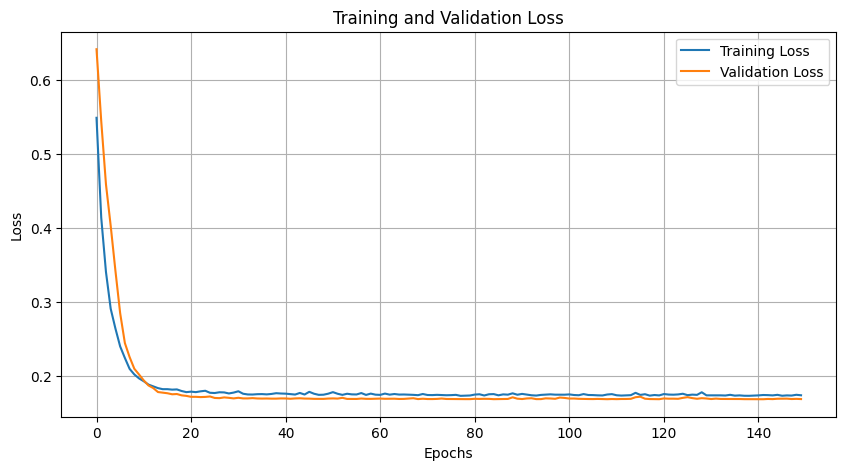

Model saved to model_exports/unet_autoencoder_final.pth
Training complete. Visualizing results...


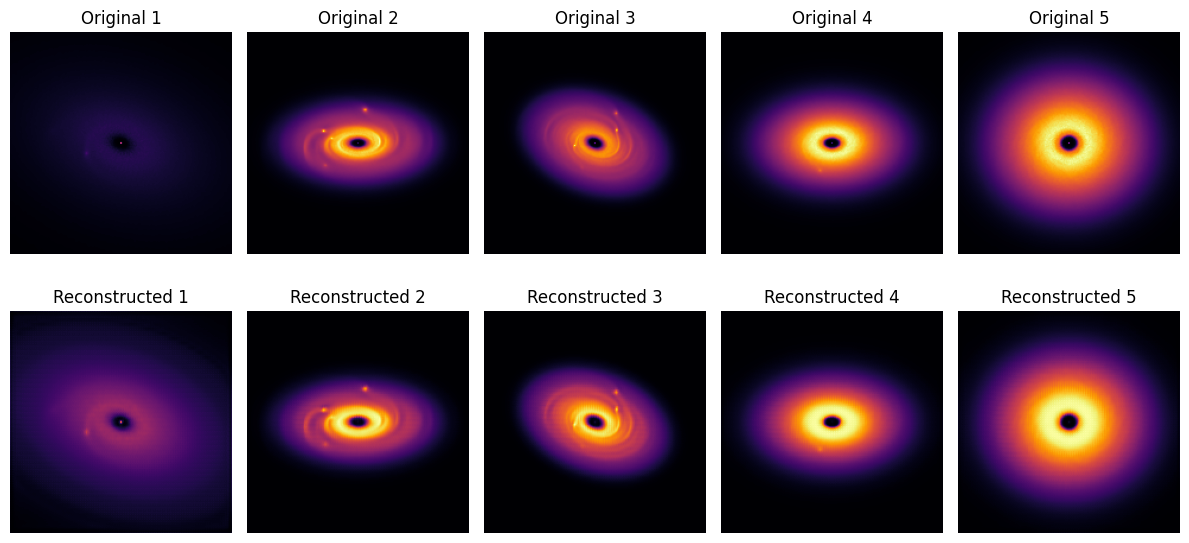

Evaluating model with quantitative metrics...


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]



Quantitative Evaluation Metrics:
Mean Squared Error (MSE): 0.000054 (the-lower-the-better)
Structural Similarity (SSIM): 0.986820 (the-higher-the-better)
Multi-Scale SSIM (MS-SSIM): 0.998217 (the-higher-the-better)


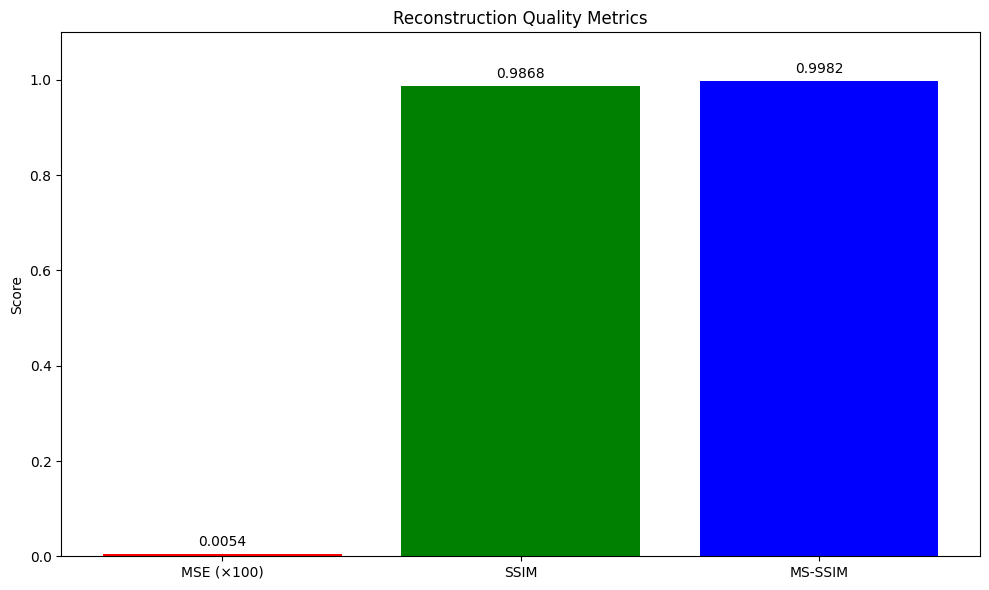

Visualizing per-image metrics...


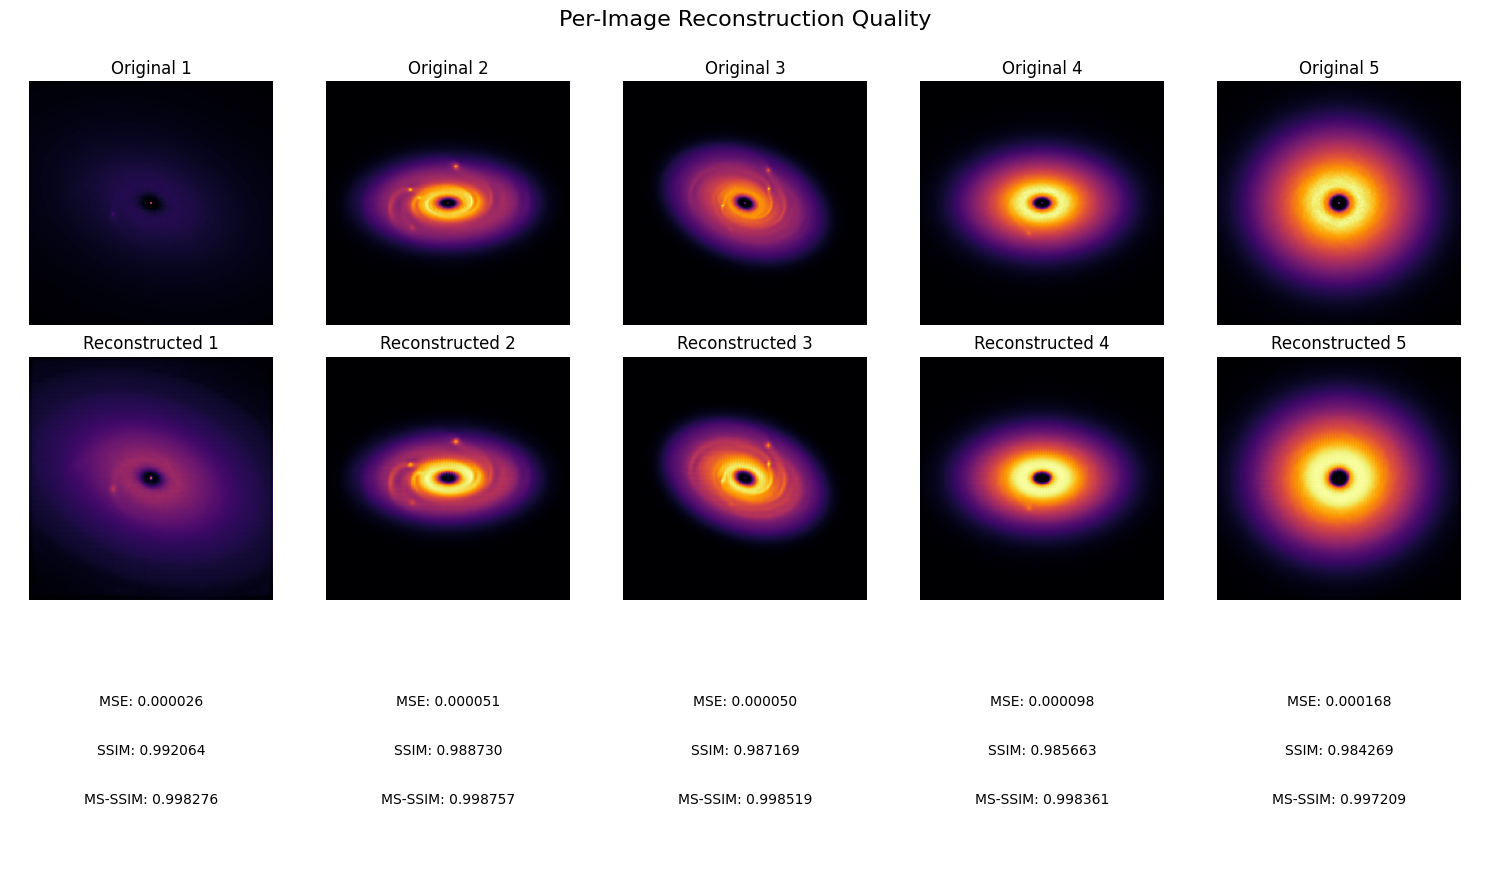

Finished!

Extracting and visualizing latent space from validation data...


Extracting latent vectors: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


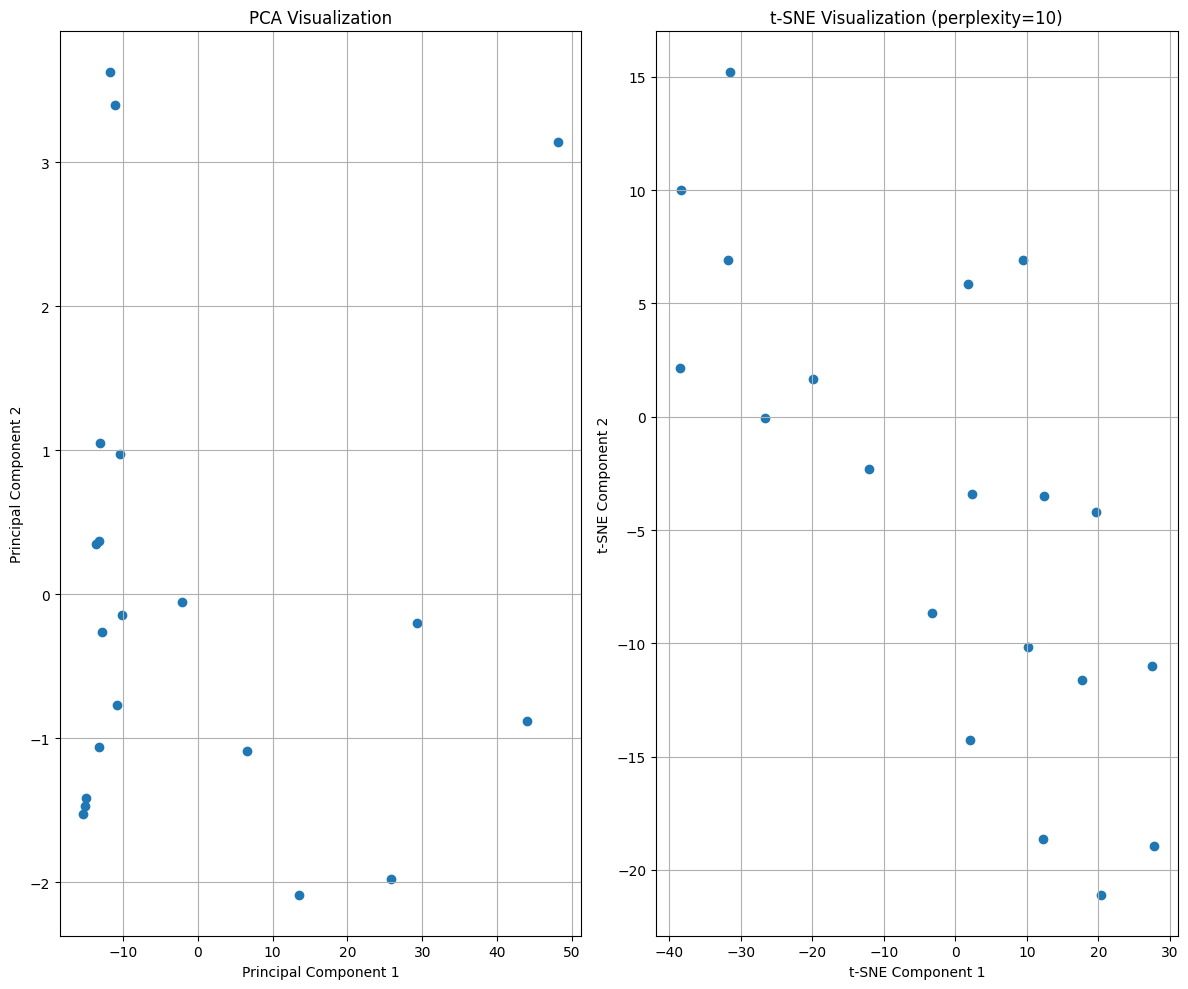

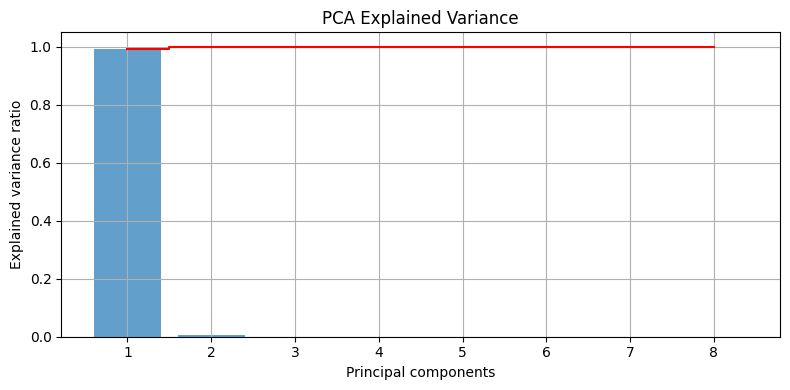


Exporting latent vectors from validation data...
Latent vectors exported to model_exports/val_latent_vectors.npz and model_exports/val_latent_vectors.csv

Visualizing specific examples from validation latent space...
Latent vector range: [-41.305286, 40.058754], mean: 3.022958
Vector 8 range: [-23.039799, 22.049719]
Decoded image 8 range: [0.006344, 0.081757], mean: 0.057856
Vector 4 range: [-41.305286, 40.058754]
Decoded image 4 range: [0.006347, 0.081841], mean: 0.056399
Vector 14 range: [-10.651205, 9.380628]
Decoded image 14 range: [0.006343, 0.081726], mean: 0.058323
Vector 13 range: [-10.380163, 9.114424]
Decoded image 13 range: [0.006343, 0.081725], mean: 0.058339
Vector 17 range: [-15.769987, 14.617877]
Decoded image 17 range: [0.006343, 0.081730], mean: 0.058031


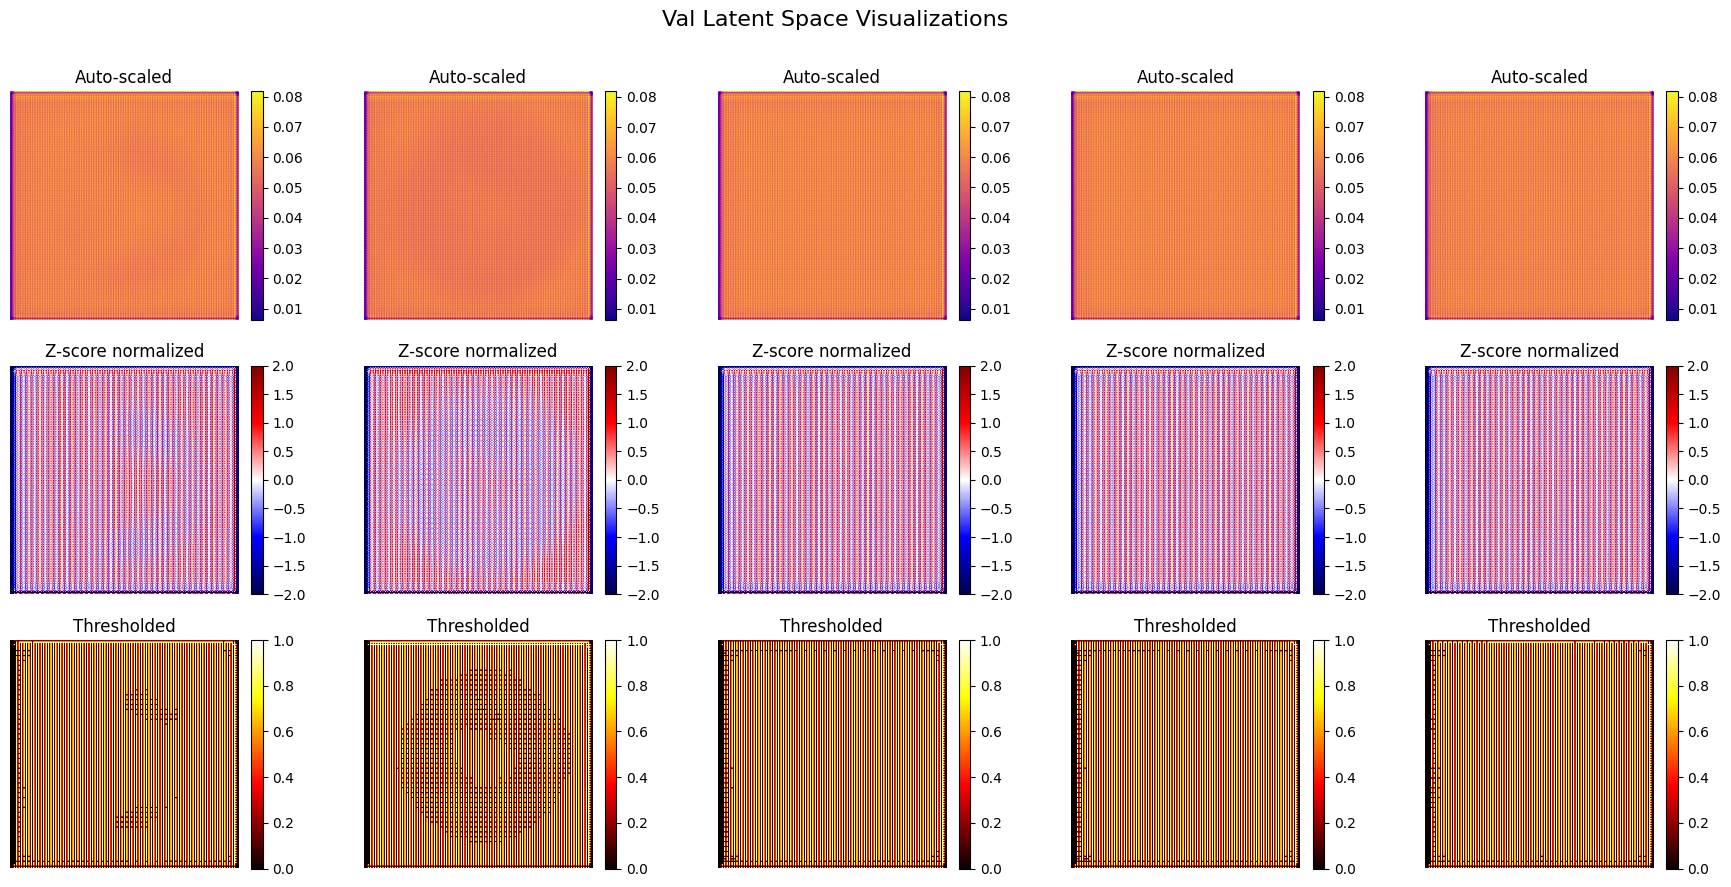

In [ ]:
if __name__ == "__main__":
    print("Loading dataset...")
    try:
        data_folder = '/kaggle/input/stardata' ########## TRAIN DIRECTORY  ###############
        os.listdir(data_folder)
    except:
        data_folder = 'data'

    print(f"Using data folder: {data_folder}")

    export_dir = 'model_exports'
    os.makedirs(export_dir, exist_ok=True)

    data_transforms = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90)
    ])

    full_dataset = loadData(data_folder, transform=None)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_dataset_augmented = loadData(data_folder, transform=data_transforms)
    train_indices = train_dataset.indices
    train_dataset_augmented = torch.utils.data.Subset(train_dataset_augmented, train_indices)

    batch_size = 16
    train_loader = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    sample_img = full_dataset[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_img.squeeze(0).numpy(), cmap='inferno', vmin=0, vmax=1)
    plt.title('Sample Preprocessed Image')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = UNet(latent_dim=8).to(device)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model has {count_parameters(model):,} trainable parameters")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 150
    print(f"Starting training for {num_epochs} epochs...")

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(export_dir, f'unet_autoencoder_checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, checkpoint_path)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_model_path = os.path.join(export_dir, 'unet_autoencoder_final.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"Model saved to {final_model_path}")

    print("Training complete. Visualizing results...")
    visualize_reconstructions(model, val_loader, device=device)

    print("Evaluating model with quantitative metrics...")
    metrics = evaluate_model(model, val_loader, device)

    print("\nQuantitative Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {metrics['MSE']:.6f} (the-lower-the-better)")
    print(f"Structural Similarity (SSIM): {metrics['SSIM']:.6f} (the-higher-the-better)")
    print(f"Multi-Scale SSIM (MS-SSIM): {metrics['MS-SSIM']:.6f} (the-higher-the-better)")

    plt.figure(figsize=(10, 6))
    metrics_names = ['MSE (×100)', 'SSIM', 'MS-SSIM']
    metrics_values = [metrics['MSE'] * 100, metrics['SSIM'], metrics['MS-SSIM']]

    bars = plt.bar(metrics_names, metrics_values, color=['red', 'green', 'blue'])
    plt.ylim([0, 1.1])
    plt.ylabel('Score')
    plt.title('Reconstruction Quality Metrics')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("Visualizing per-image metrics...")
    per_image_metrics = visualize_per_image_metrics(model, val_loader, device=device)
    print("Finished!")

    print("\nExtracting and visualizing latent space from validation data...")
    latent_vectors, image_names = extract_latent_representations(model, val_loader, device)

    visualize_latent_space(latent_vectors, image_names)

    print("\nExporting latent vectors from validation data...")
    export_filepath = os.path.join(export_dir, "val_latent_vectors")
    export_df = export_latent_vectors(latent_vectors, image_names, export_filepath)



    print("\nVisualizing specific examples from validation latent space...")
    visualize_latent_features(model, latent_vectors, image_names, device, export_dir=export_dir, prefix="val")


### These images were hard to see due to large variation, hence different techniques were employed to make their visualization better

# INFERENCE ON TEST DATA


RUNNING TEST DATA INFERENCE
Using device: cuda
Using Kaggle test data folder: /kaggle/input/stardata
Model path: /kaggle/working/model_exports/unet_autoencoder_final.pth
Metrics will be saved to: test_results/test_metrics.txt
Visualizations will be saved to: test_results


<ipython-input-39-0ea5a7fc555d>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Inferring: 100%|████████

Metrics saved to test_results/test_metrics.txt


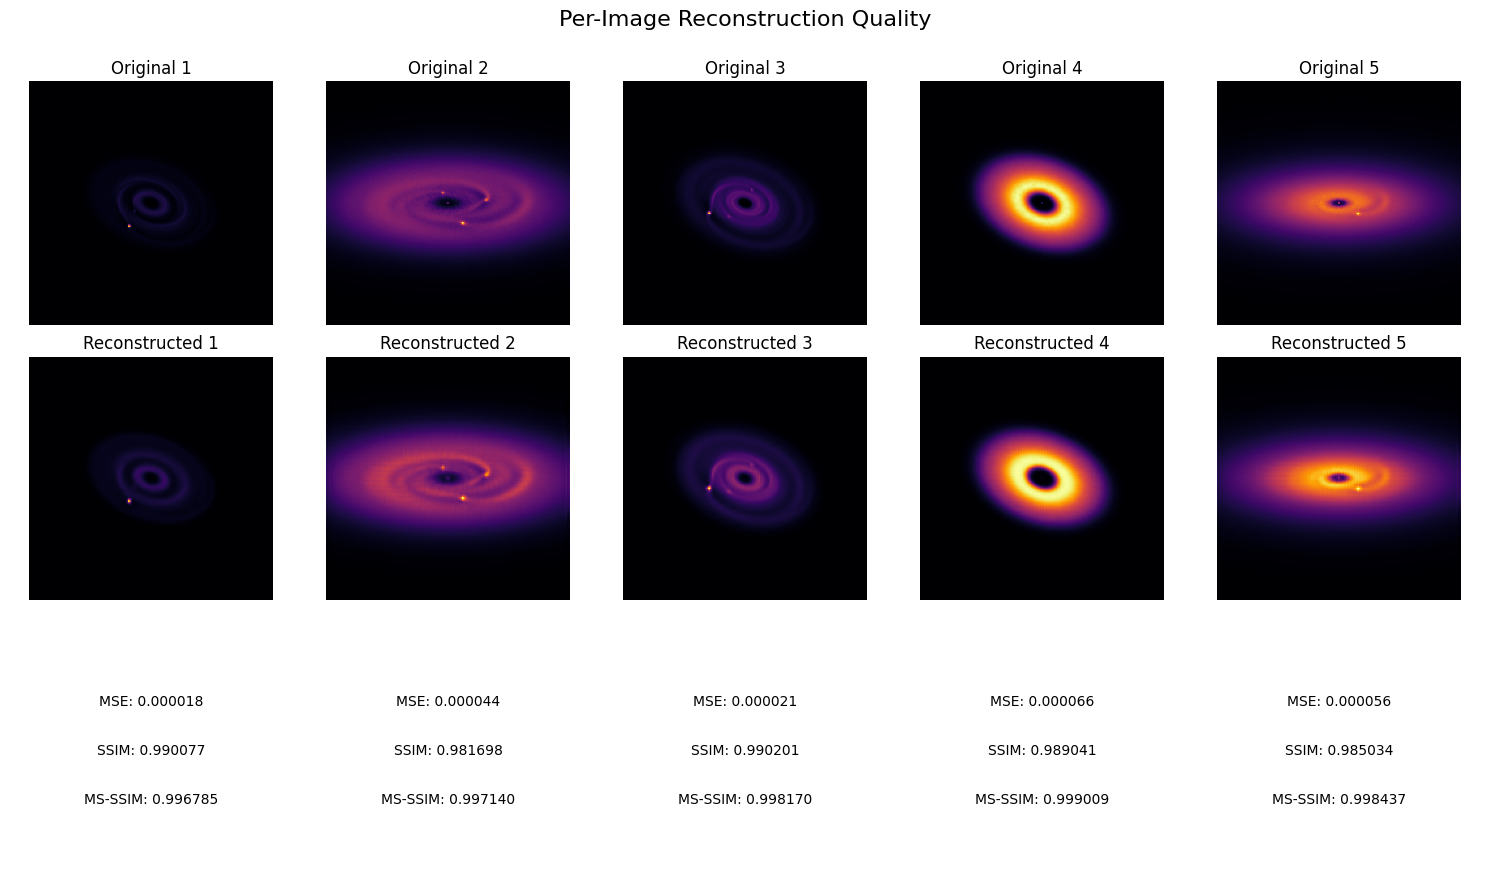


Extracting and visualizing latent space from test data...


Extracting latent vectors: 100%|██████████| 25/25 [00:00<00:00, 26.58it/s]


Latent vector range in test data: [-62.049610, 58.915951]


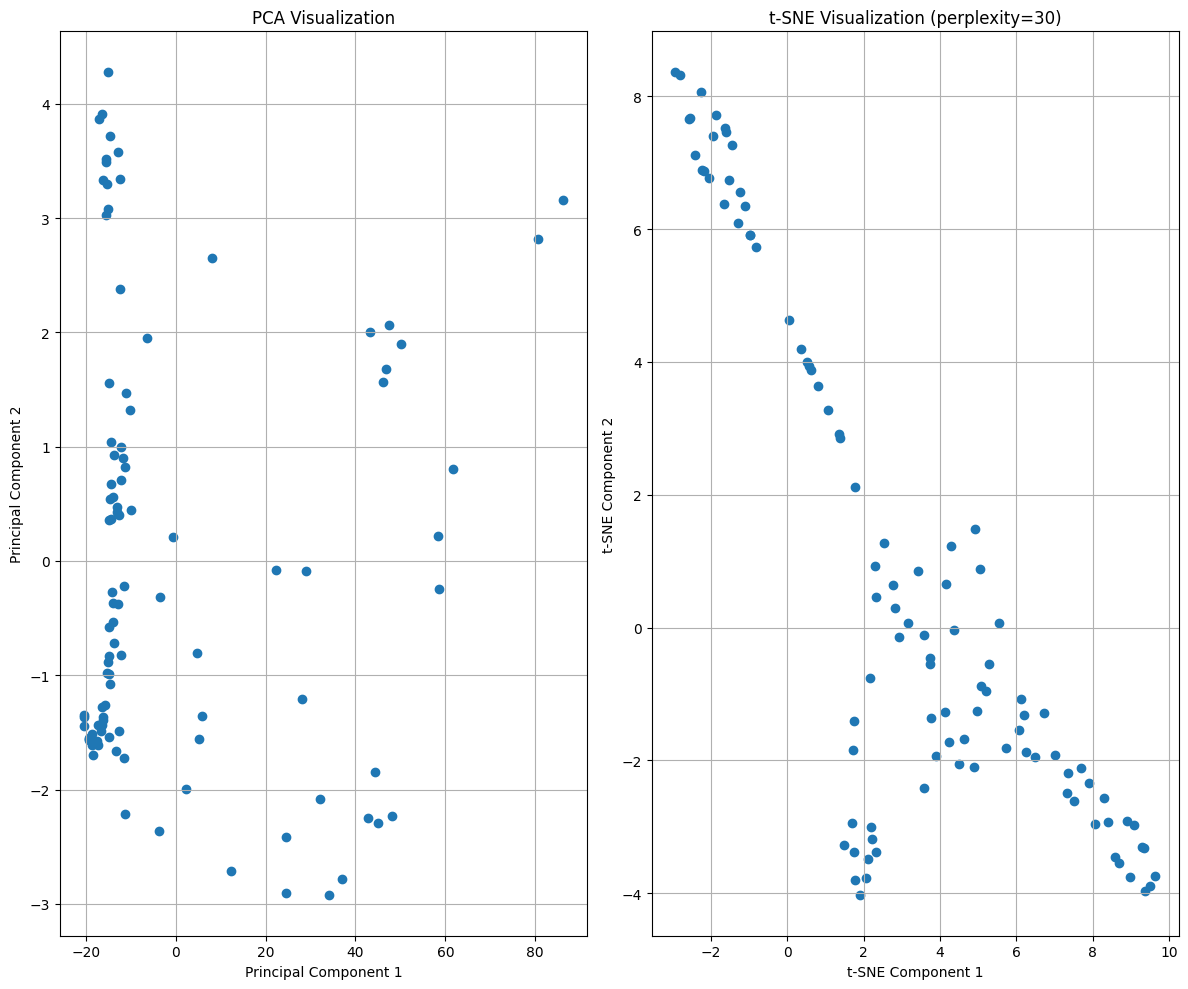

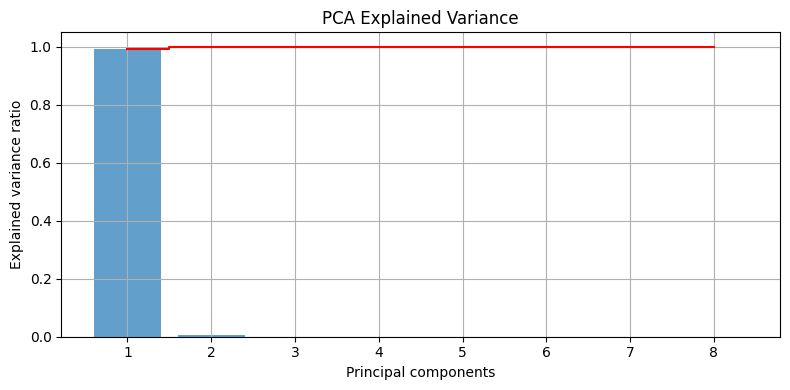


Exporting latent vectors from test data...
Latent vectors exported to test_results/test_latent_vectors.npz and test_results/test_latent_vectors.csv

Visualizing specific examples from test latent space...
Using specified indices for latent space visualization: [0, 7, 5, 83, 91, 16, 54]
Vector 0 range: [-39.695747, 37.964123]
Vector 7 range: [-10.507480, 9.441331]
Vector 5 range: [-10.271974, 8.829017]
Vector 83 range: [-9.955967, 8.447421]
Vector 91 range: [-12.345490, 11.164256]
Vector 16 range: [-8.365206, 6.976706]
Vector 54 range: [-62.049610, 58.915951]


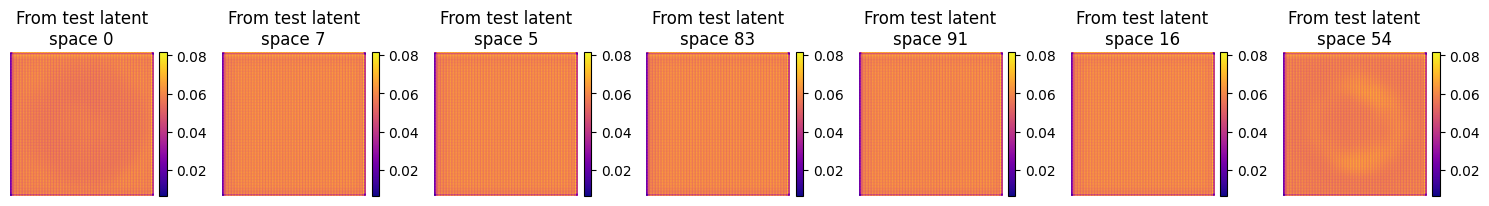


Saving example reconstructed images from test latent space...

Analyzing original test image 0:
Latent vector for image 0:
[ 35.88705   -21.537632   28.32457     6.8440766 -39.695747   -7.7770977
  18.278505   37.964123 ]
Range: [-39.695747, 37.964123]


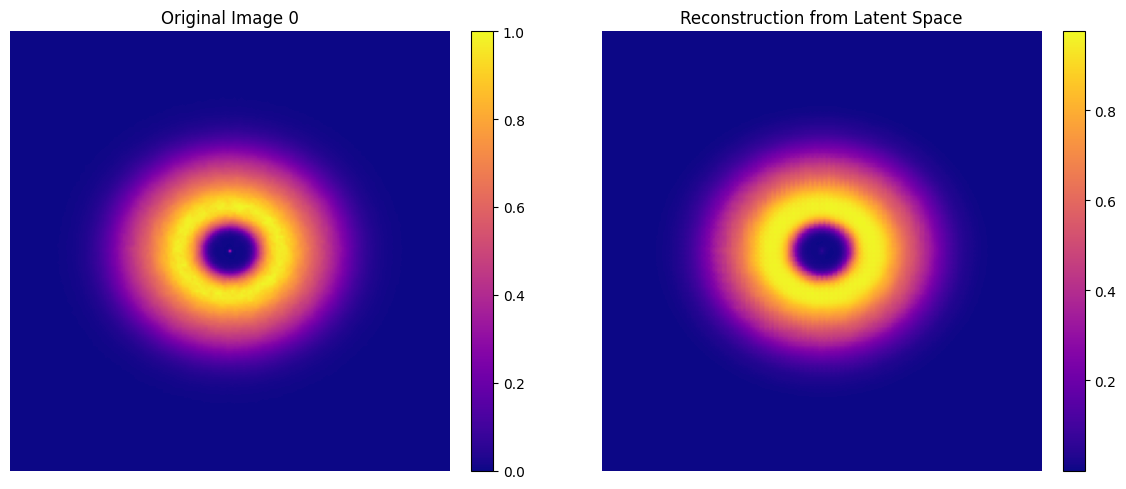


Analyzing original test image 7:
Latent vector for image 7:
[  8.034394   -3.753061    5.4725575   1.2501202 -10.50748    -1.8822263
   5.977686    9.441331 ]
Range: [-10.507480, 9.441331]


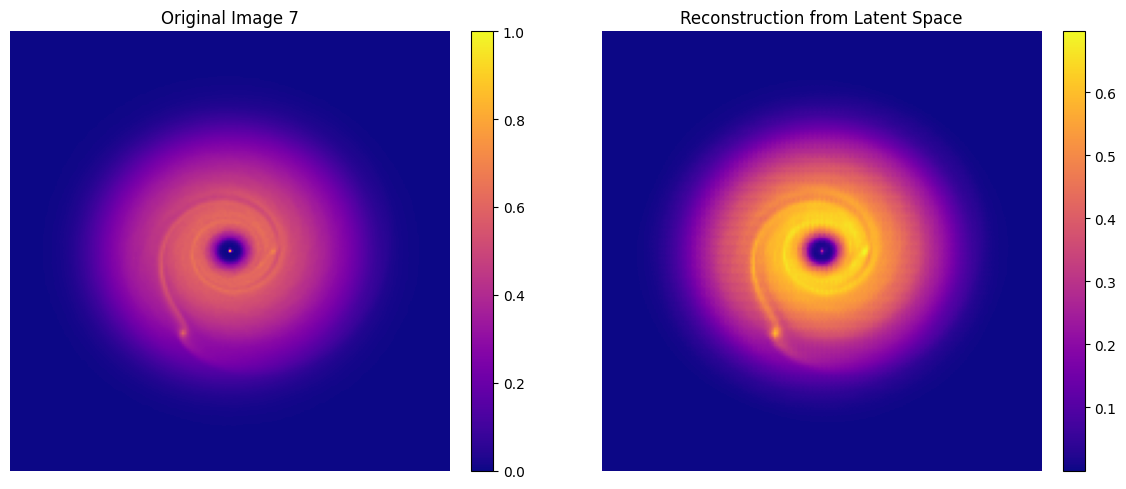


Analyzing original test image 5:
Latent vector for image 5:
[  7.916135   -3.973154    4.8082204   0.9928142 -10.271974   -1.1220998
   5.493398    8.829017 ]
Range: [-10.271974, 8.829017]


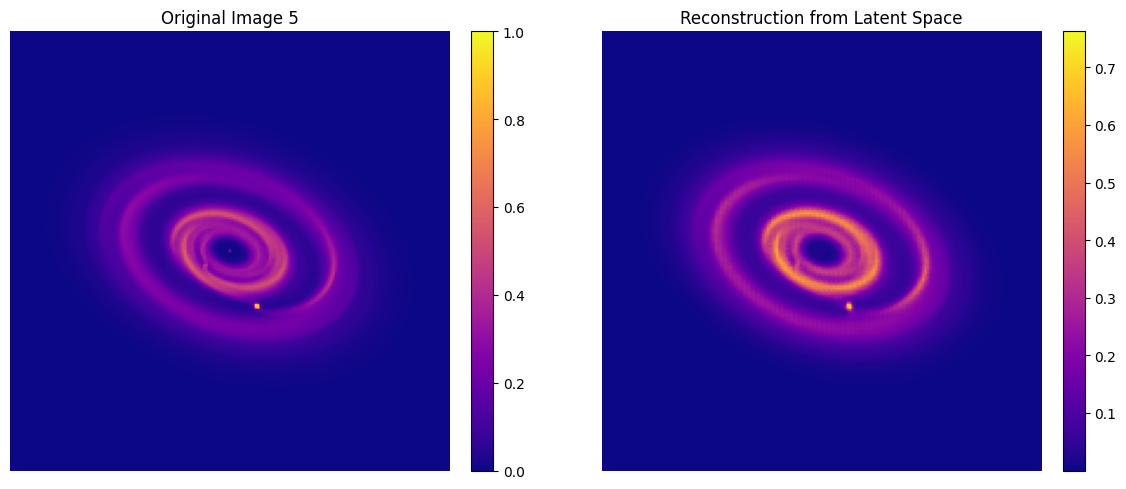


Analyzing original test image 83:
Latent vector for image 83:
[ 7.8295417 -4.116928   4.538409   0.7823842 -9.955967  -0.8880173
  5.235197   8.447421 ]
Range: [-9.955967, 8.447421]


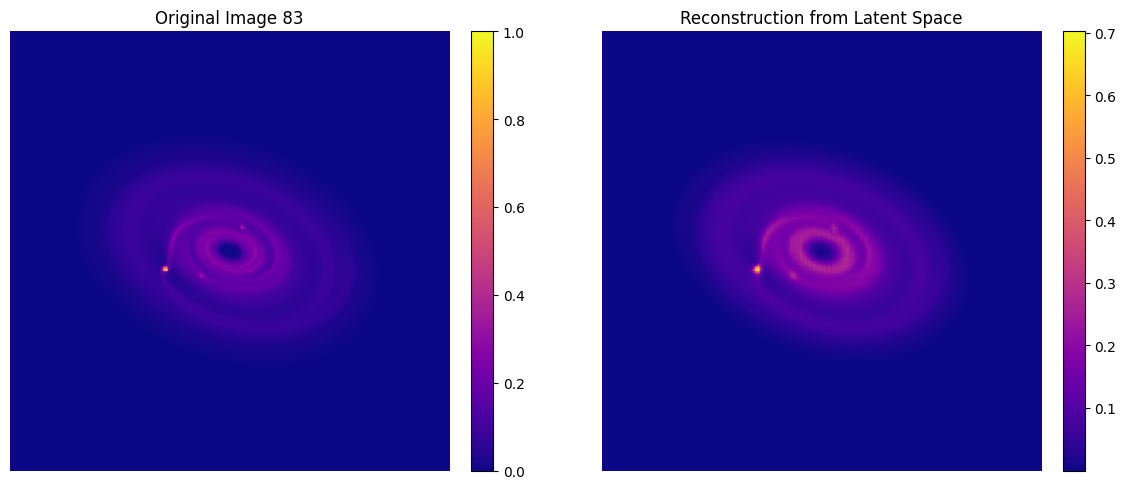


Analyzing original test image 91:
Latent vector for image 91:
[  9.922526    -5.631196     6.38224     -0.44472235 -12.3454895
  -0.97656065   4.531728    11.164256  ]
Range: [-12.345490, 11.164256]


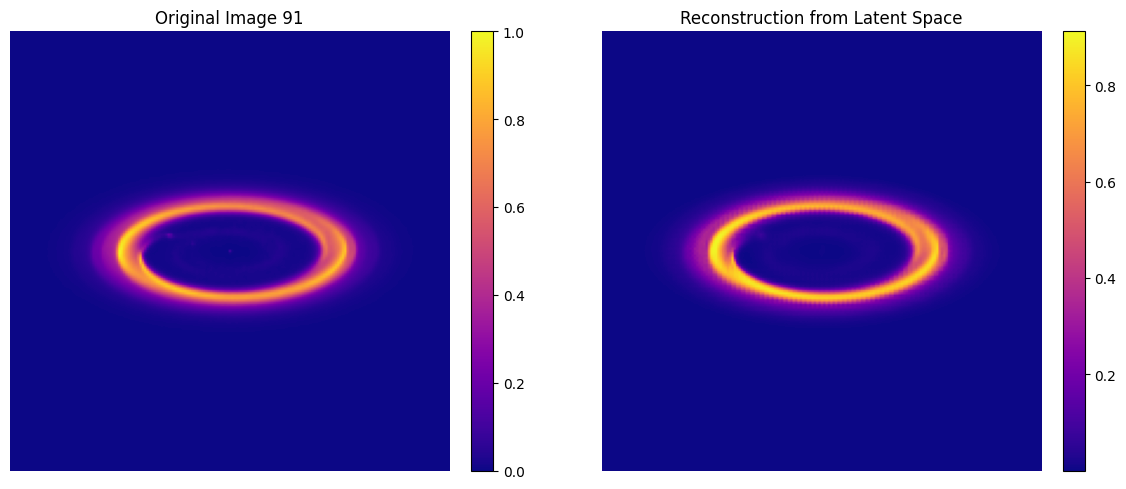


Analyzing original test image 16:
Latent vector for image 16:
[ 6.5066757  -3.4881577   3.4089916   0.34942153 -8.365206   -0.47017425
  4.5082984   6.9767056 ]
Range: [-8.365206, 6.976706]


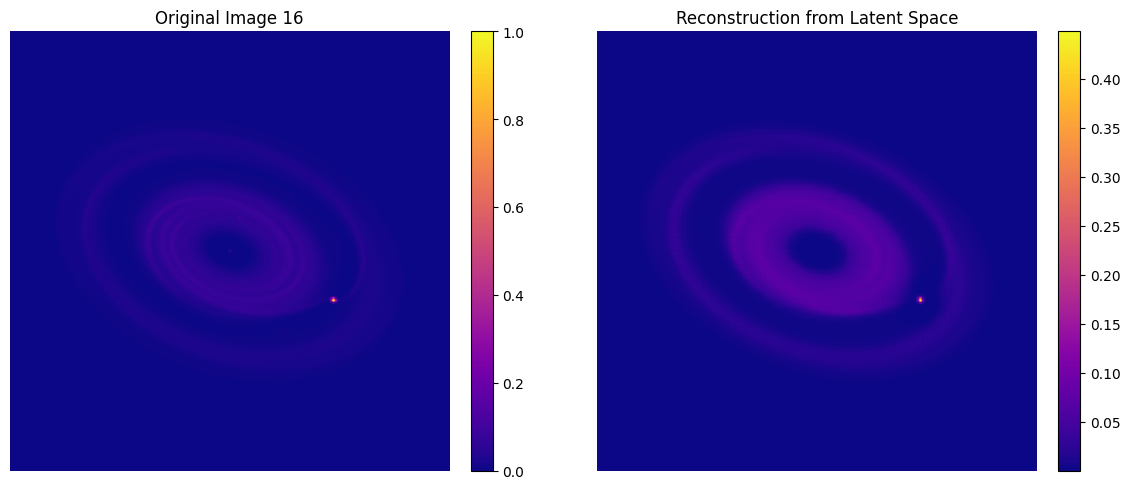


Analyzing original test image 54:
Latent vector for image 54:
[ 54.89309  -29.22523   42.20353   12.395003 -62.04961  -15.773527
  27.690737  58.91595 ]
Range: [-62.049610, 58.915951]


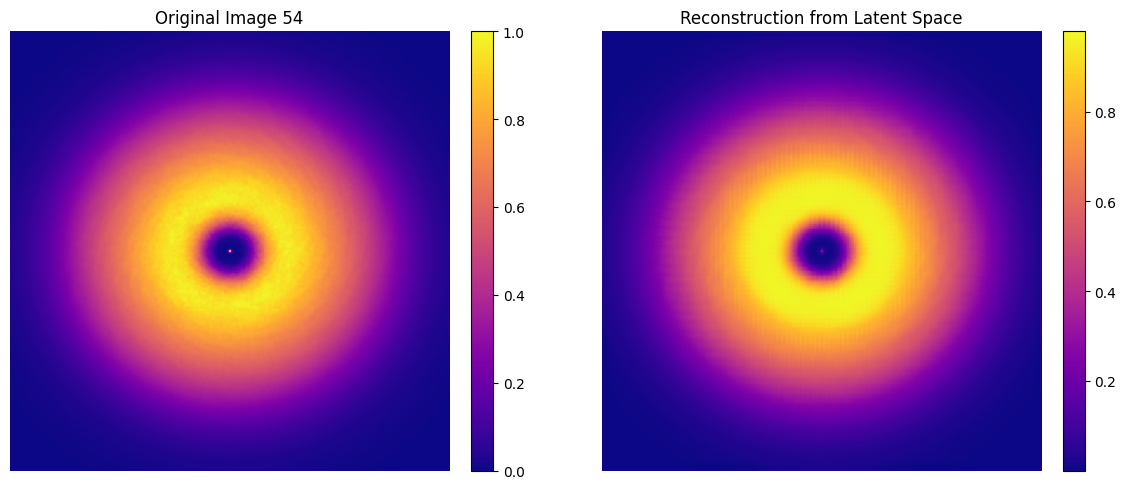


Test inference complete!


In [ ]:
test_metrics = run_test_inference(specific_indices=[0,7, 5, 83,91,16, 54])    # choose any idexes from the dataset, no choice leads to random selection